## data import and structuring

In [2]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# fetch dataset 
energy_efficiency = fetch_ucirepo(id=242) 
  
# data
X = energy_efficiency.data.features 
y = energy_efficiency.data.targets 
  
# energy_efficiency.metadata # metadata
# energy_efficiency.variables # variabels

'''maybe fit a model first to reduce, do pca eigenvalues, and then xgboost the data?'''
''' this is not nessesary for this dataset, we only have 10 columns and they are all very clean'''

# define feature names as the ones provided are labeled as X1 X2...
feature_names = [
    'Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area',
    'Overall Height', 'Orientation', 'Glazing Area', 'Glazing Area Distribution'
]

# target names, we have two
target_names = ['Heating Load', 'Cooling Load']

# assign names we made
X.columns = feature_names
y.columns = target_names

In [3]:
# combine x and y into one dataframe for easy visuals
df = pd.concat([X, y], axis=1)
df

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


## univariate analysis

In [4]:
'''simple stats for each of the variables'''
df.describe()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


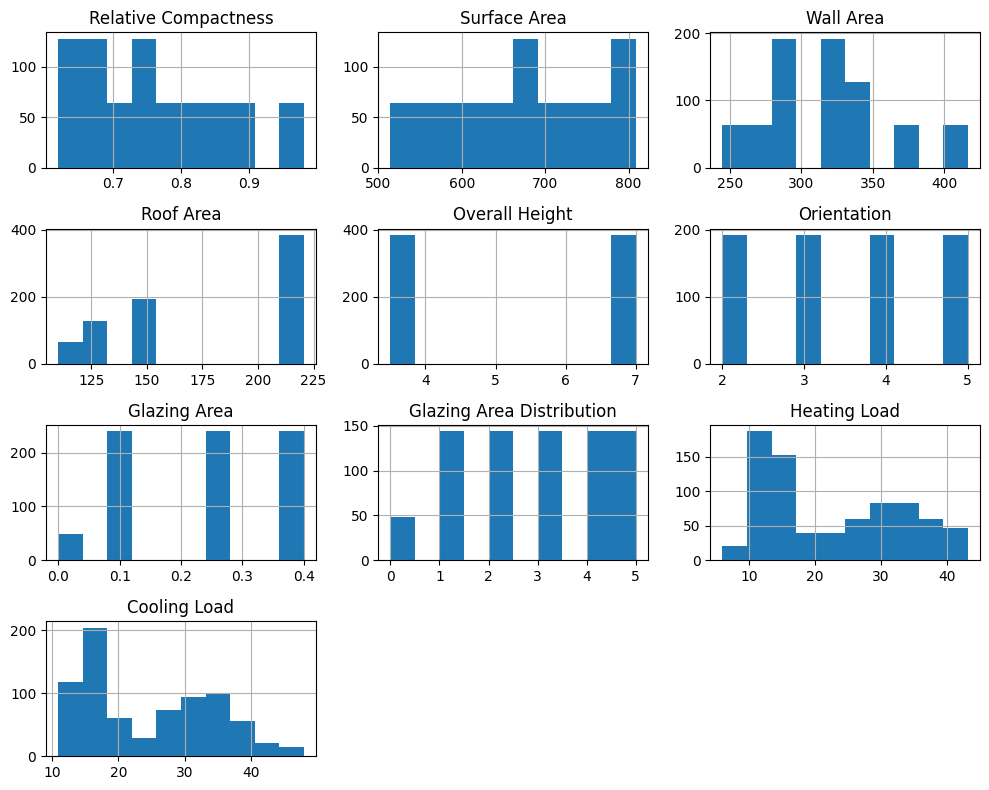

In [5]:
import seaborn as sns

df.hist(figsize=(10,8))
plt.tight_layout()
plt.show()

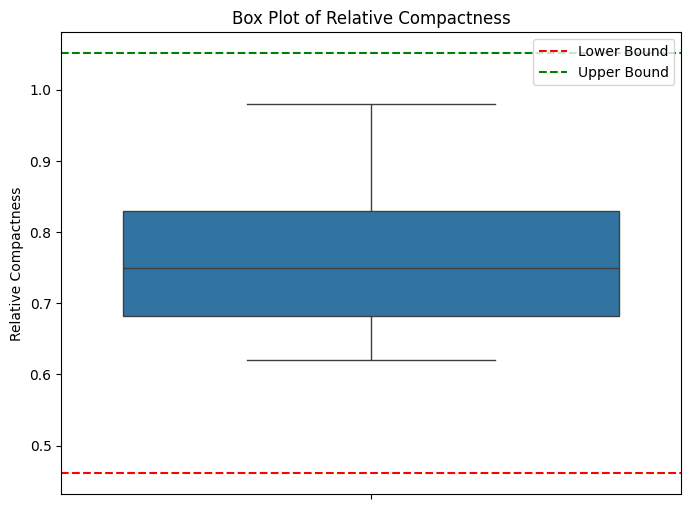

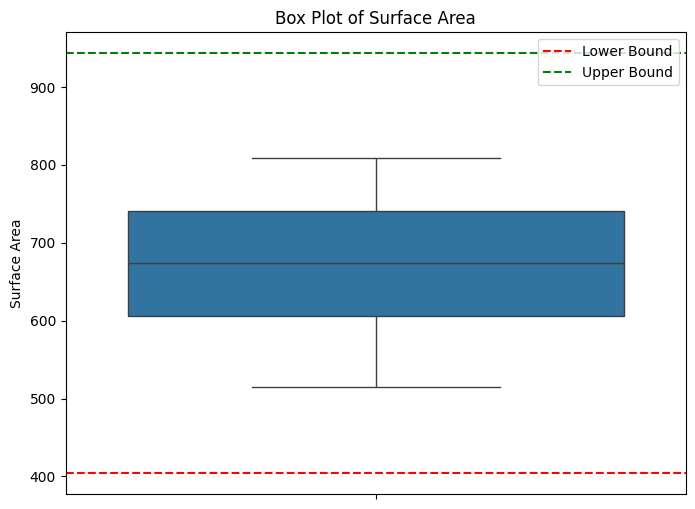

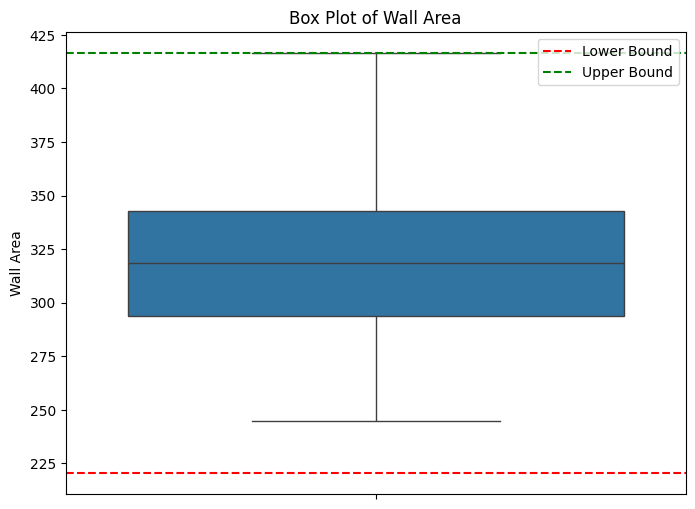

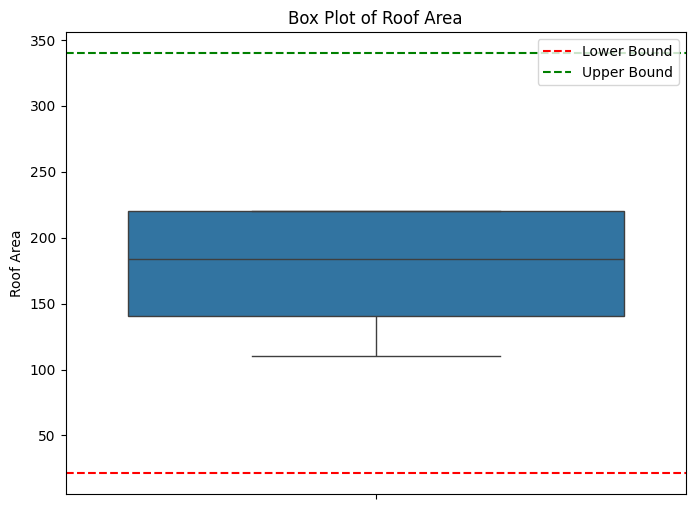

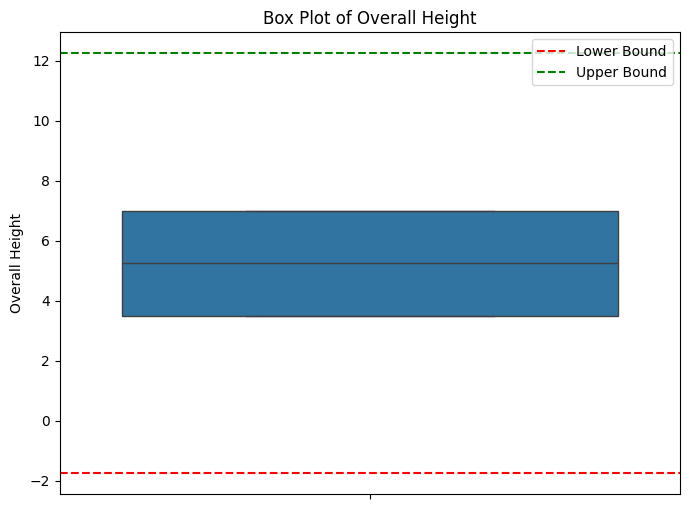

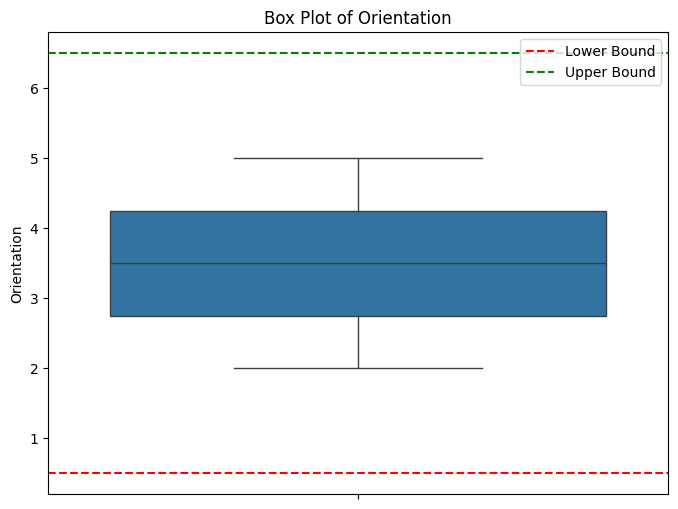

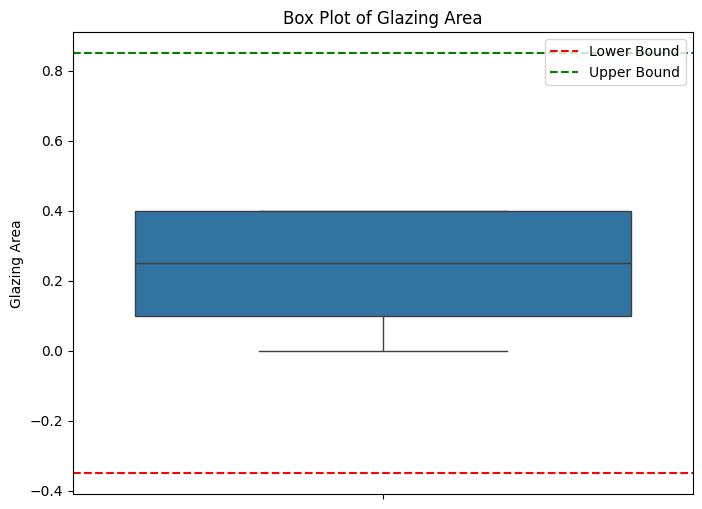

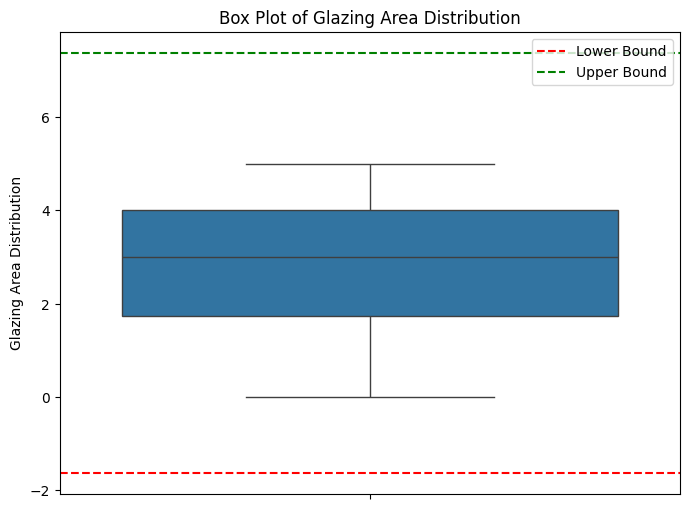

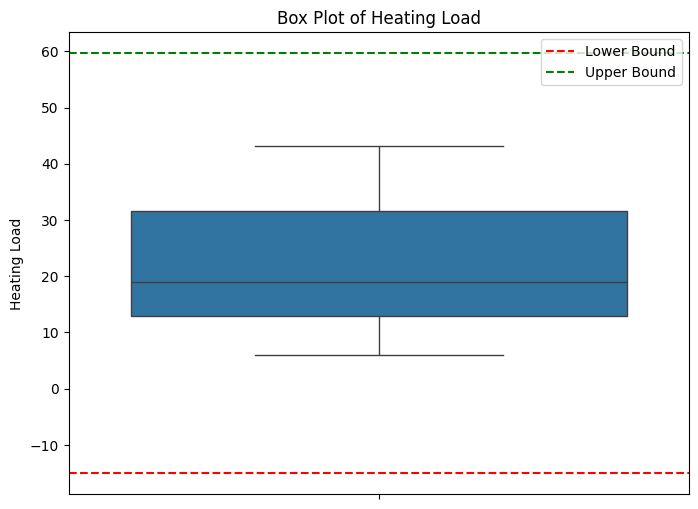

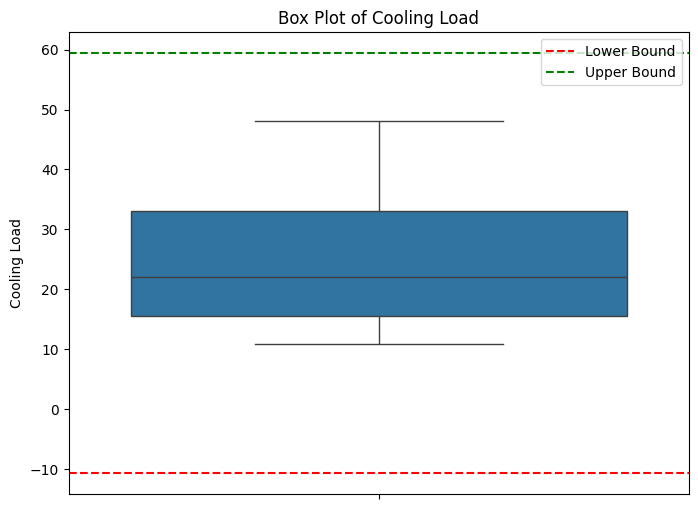

In [15]:
# Plot box plots with IQR bounds
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:
        plt.figure(figsize=(8, 6))
        sns.boxplot(y=df[column])
        plt.title(f'Box Plot of {column}')
        plt.ylabel(column)
        
        # Calculate bounds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Add lines for bounds
        plt.axhline(y=lower_bound, color='red', linestyle='--', label='Lower Bound')
        plt.axhline(y=upper_bound, color='green', linestyle='--', label='Upper Bound')
        plt.legend()
        plt.show()


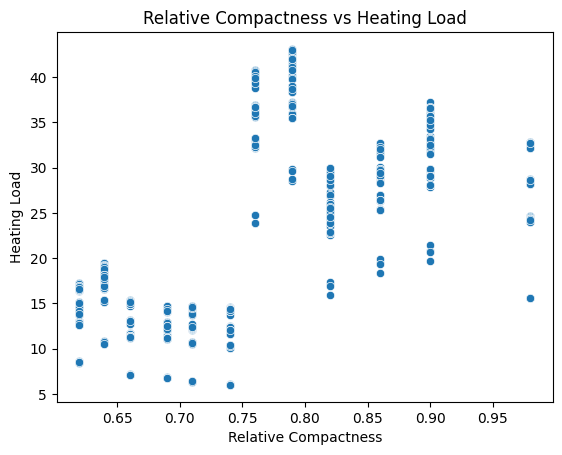

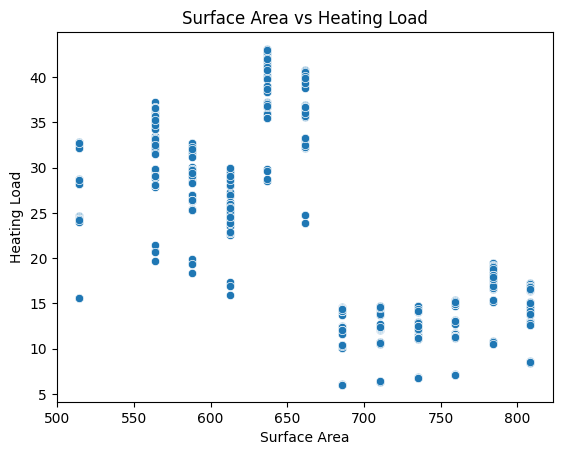

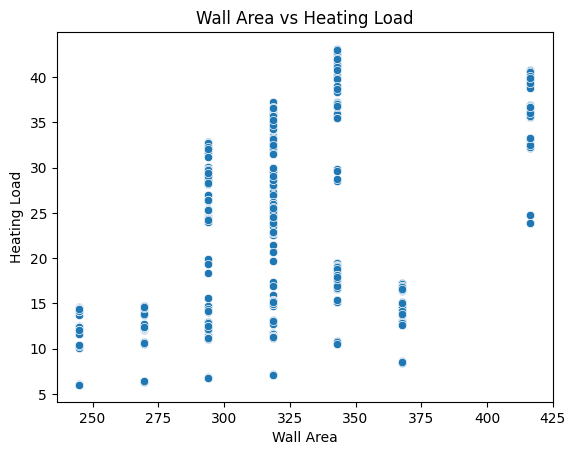

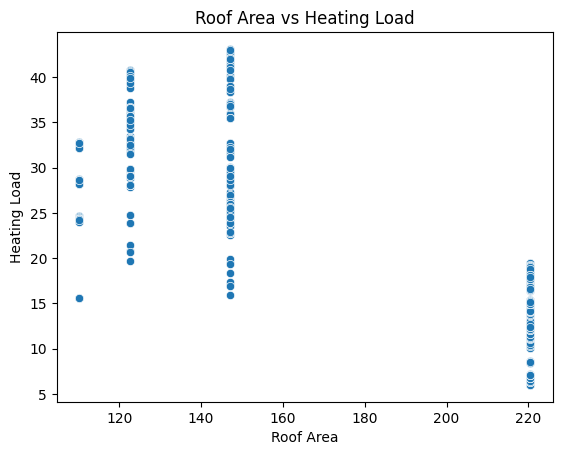

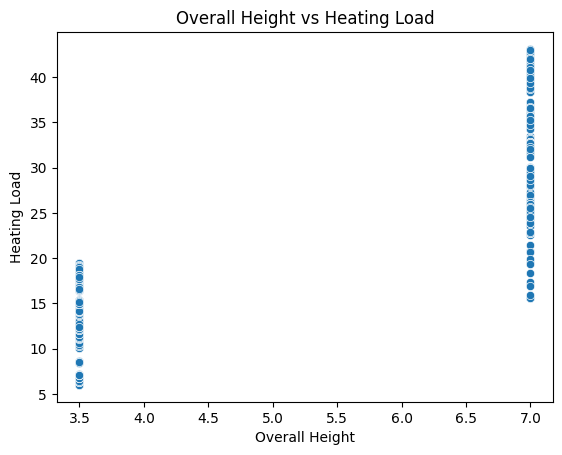

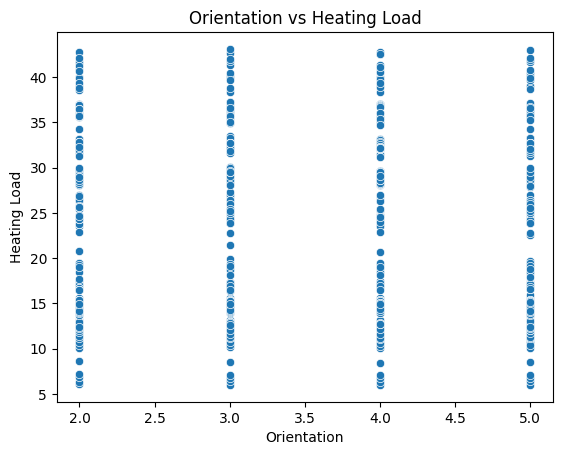

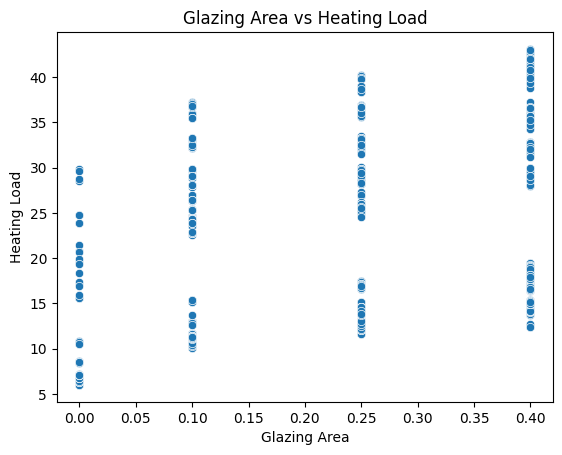

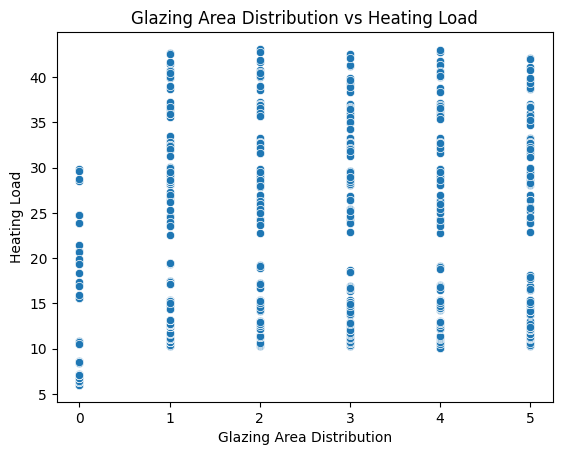

In [7]:
# scatter plots
for feature in feature_names:
    plt.figure()
    sns.scatterplot(x=df[feature], y=df['Heating Load'])
    plt.title(f'{feature} vs Heating Load')
    plt.show()


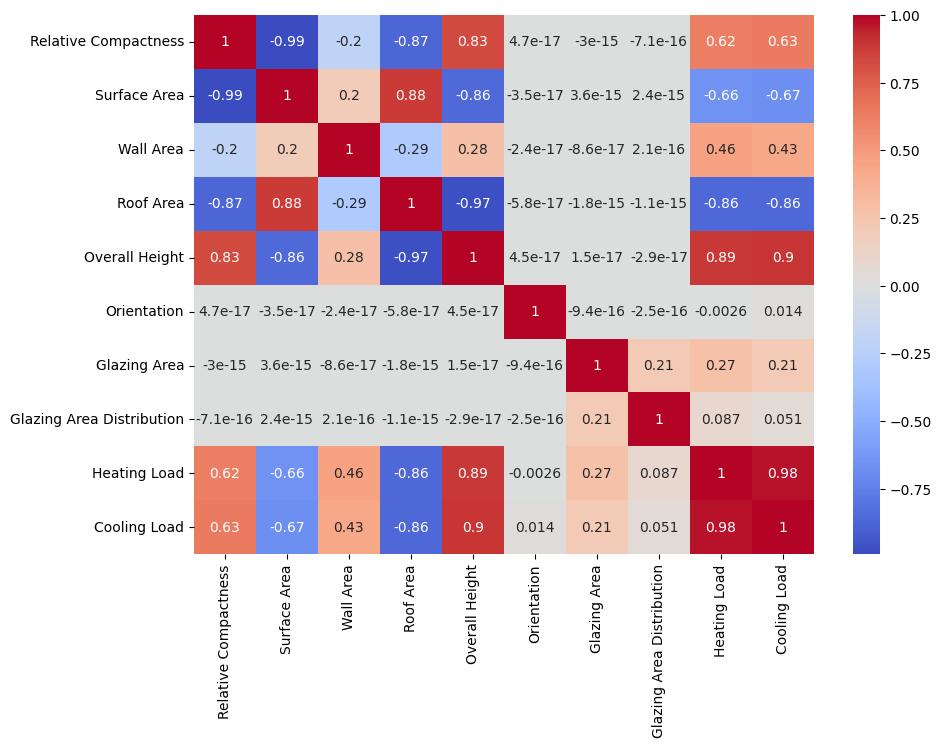

In [8]:
# corr matrix
corr_matrix = df.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


## Modeling

### split the data into a train and test set for modeling

In [9]:
# split data into train test split at 20% test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Oridinary Least Squares Regression

In [10]:
from sklearn.linear_model import LinearRegression

ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

y_pred_ols = ols_model.predict(X_test)

mse_ols = mean_squared_error(y_test, y_pred_ols)
rmse_ols = np.sqrt(mse_ols)
r2_ols = r2_score(y_test, y_pred_ols)
print('OLS Test RMSE:', rmse_ols)
print('OLS Test R^2 Score:', r2_ols)

OLS Test RMSE: 3.085994707339771
OLS Test R^2 Score: 0.9027041137649523


### Elastic Net

In [11]:
from sklearn.linear_model import ElasticNet

param_grid_enet = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9]
}

grid_search_enet = GridSearchCV(ElasticNet(), param_grid_enet, cv=5, scoring='neg_mean_squared_error')
grid_search_enet.fit(X_train, y_train)


best_enet = grid_search_enet.best_estimator_
print('Best Elastic Net Parameters:', grid_search_enet.best_params_)

# Predictions and evaluation
y_pred_enet = best_enet.predict(X_test)
mse_enet = mean_squared_error(y_test, y_pred_enet)
rmse_enet = np.sqrt(mse_enet)
r2_enet = r2_score(y_test, y_pred_enet)
print('Elastic Net Test RMSE:', rmse_enet)
print('Elastic Net Test R^2 Score:', r2_enet)


Best Elastic Net Parameters: {'alpha': 0.01, 'l1_ratio': 0.9}
Elastic Net Test RMSE: 3.1740007830944497
Elastic Net Test R^2 Score: 0.8970985234894209


### XGBoost

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters found:
subsample: 0.7
n_estimators: 300
min_child_weight: 1
max_depth: 7
learning_rate: 0.05
colsample_bytree: 0.8

Training Metrics:
RMSE: 0.0602
R²: 1.0000

Test Metrics:
RMSE: 0.6002
R²: 0.9965


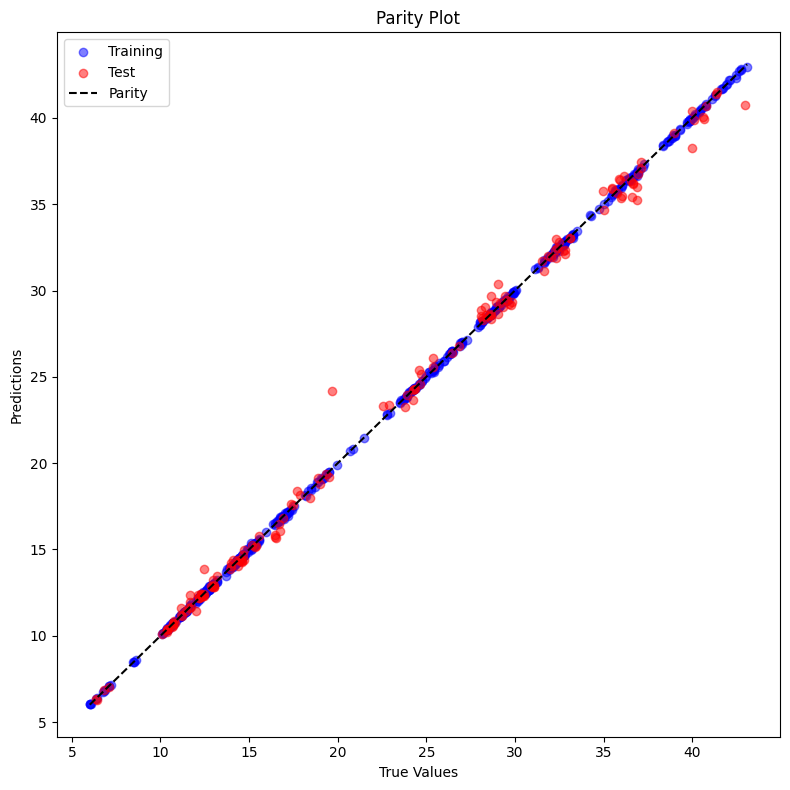

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from ucimlrepo import fetch_ucirepo

class XGBoostRegressor:
    def __init__(self, data: pd.DataFrame, target_var: str, random_state: int = 42):
        self.data = data
        self.target_var = target_var
        self.random_state = random_state
        self.model = None
        self.best_params = None
        
    def preprocess_data(self, test_size=0.2):
        # separate features and target
        X = self.data.drop(columns=[self.target_var])
        y = self.data[self.target_var]
        
        # split into train and test
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state
        )
        
    def random_search(self, n_iter=100):
        # define parameter space
        param_space = {
            'max_depth': [3, 4, 5, 6, 7, 8],
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [100, 200, 300, 400, 500],
            'min_child_weight': [1, 3, 5],
            'subsample': [0.7, 0.8, 0.9],
            'colsample_bytree': [0.7, 0.8, 0.9]
        }
        
        # init model
        base_model = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=self.random_state
        )
        
        # init random search
        random_search = RandomizedSearchCV(
            estimator=base_model,
            param_distributions=param_space,
            n_iter=n_iter,
            cv=5,
            random_state=self.random_state,
            n_jobs=-1,
            verbose=1,
            scoring='neg_mean_squared_error'
        )
        
        # fit random search
        random_search.fit(self.X_train, self.y_train)
        
        # store best params and model
        self.best_params = random_search.best_params_
        self.model = random_search.best_estimator_
        
        print("\nBest parameters found:")
        for param, value in self.best_params.items():
            print(f"{param}: {value}")
            
    def evaluate_model(self):
        """Print evaluation metrics on test set"""
        train_pred = self.model.predict(self.X_train)
        test_pred = self.model.predict(self.X_test)
        
        print("\nTraining Metrics:")
        print(f"RMSE: {np.sqrt(mean_squared_error(self.y_train, train_pred)):.4f}")
        print(f"R²: {r2_score(self.y_train, train_pred):.4f}")
        
        print("\nTest Metrics:")
        print(f"RMSE: {np.sqrt(mean_squared_error(self.y_test, test_pred)):.4f}")
        print(f"R²: {r2_score(self.y_test, test_pred):.4f}")
            
    def plot_parity(self):
        """Generate parity plot comparing predictions vs actual values"""
        plt.figure(figsize=(8, 8))
        
        # predictions
        train_pred = self.model.predict(self.X_train)
        test_pred = self.model.predict(self.X_test)
        
        # plot each set
        plt.scatter(self.y_train, train_pred, alpha=0.5, label='Training', color='blue')
        plt.scatter(self.y_test, test_pred, alpha=0.5, label='Test', color='red')
        
        #parity line
        all_values = np.concatenate([self.y_train, self.y_test])
        all_preds = np.concatenate([train_pred, test_pred])
        min_val = min(all_values.min(), all_preds.min())
        max_val = max(all_values.max(), all_preds.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Parity')
        
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.title('Parity Plot')
        plt.legend()
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    # dataset
    energy_efficiency = fetch_ucirepo(id=242)
    X = energy_efficiency.data.features
    y = energy_efficiency.data.targets

    # column names
    feature_names = [
        'Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area',
        'Overall Height', 'Orientation', 'Glazing Area', 'Glazing Area Distribution'
    ]
    target_names = ['Heating Load', 'Cooling Load']
    X.columns = feature_names
    y.columns = target_names

    # combine features and targets
    data = pd.concat([X, y], axis=1)

    # create and train model
    model = XGBoostRegressor(data, target_var='Heating Load')
    model.preprocess_data()
    
    # random search with 100 iterations
    model.random_search(n_iter=100)
    
    # evaluate and plot results
    model.evaluate_model()
    model.plot_parity()

In [13]:
# 3. Model Comparison
print('\nModel Comparison:')
print(f'OLS RMSE: {rmse_ols:.4f}, R^2: {r2_ols:.4f}')
print(f'Elastic Net RMSE: {rmse_enet:.4f}, R^2: {r2_enet:.4f}')


Model Comparison:
OLS RMSE: 3.0860, R^2: 0.9027
Elastic Net RMSE: 3.1740, R^2: 0.8971


### approach with hyperopt

In [14]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Prepare data
def get_data():
    from ucimlrepo import fetch_ucirepo
    energy_efficiency = fetch_ucirepo(id=242)
    X = energy_efficiency.data.features
    y = energy_efficiency.data.targets['Y1']
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Define objective function
def objective(params):
    # Convert hyperopt values to proper types
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    
    # Create and train model
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    
    # Evaluate
    pred = model.predict(X_val)
    loss = mean_squared_error(y_val, pred)
    
    return {'loss': loss, 'status': STATUS_OK}

# Define search space
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.quniform('n_estimators', 100, 500, 100),
    'objective': 'reg:squarederror'
}

if __name__ == "__main__":

    X_train, X_val, y_train, y_val = get_data()
    
    # optimize
    trials = Trials()
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=10,
        trials=trials
    )
    
    print("\nBest parameters found:")
    print(f"max_depth: {int(best['max_depth'])}")
    print(f"learning_rate: {best['learning_rate']:.4f}")
    print(f"n_estimators: {int(best['n_estimators'])}")

100%|██████████| 10/10 [00:01<00:00,  5.13trial/s, best loss: 0.14656348654199947]

Best parameters found:
max_depth: 6
learning_rate: 0.2239
n_estimators: 200
